<h1 align="center">IntelyCare Data Challenge</h1>

<h5 align="right">Saundarya Badhrinathan</h5>

## 1. Problem Statement

#### Based on information observed more than 6 days prior to a given day:
- How many total requests can I expect for shifts on that day?
- How many total requests net of deletions can I expect to see on the day of the shift?
____

## 2. Assumptions made
- 'RequestId' is not unique. This is because it is assumed that if a facility has made a request for multiple shift vacancies for the same date and shift duration, there are multiple observations created with the same 'RequestId'.
- 'RequestHours' cannot be 0 or negative as length of shift needs to be a positive value.
- 'Lag' days cannot be negative.
- 'Lag' greater than 60 days might be erronious data.
___

## 3. Loading data
### 3.1 Importing required packages

In [60]:
import pandas as pd
from pandas import *
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from pylab import rcParams
import statsmodels.api as sm

import warnings
import itertools

### 3.2 Reading file into notebook

In [61]:
data = pd.read_csv("new_shift_info.csv")
data.head(n=10)

,RequestId,Market,CareDateTime,RequestTime,RequestHours,TimeGroup,RequestQualification,AcceptTime,status,FinalStatusTime
0,246068,BOS-South,10/28/18 7:00,10/23/17 16:02,8.0,DT,CNA,NaN,Deleted,3/7/18 12:29
1,246070,BOS-South,10/28/18 7:00,10/23/17 16:03,8.0,DT,CNA,NaN,Deleted,3/7/18 12:29
2,246072,BOS-South,10/28/18 7:00,10/23/17 16:03,8.0,DT,CNA,NaN,Deleted,3/7/18 12:29
3,246078,BOS-South,10/28/18 7:00,10/23/17 16:18,8.0,DT,CNA,NaN,Deleted,3/7/18 12:29
4,253828,BOS-North,10/24/18 23:00,10/30/17 16:18,8.0,NT,CNA,NaN,Deleted,3/7/18 11:29
5,509008,BOS-North,10/4/18 15:00,6/4/18 9:24,8.0,ET,Nurse,NaN,Deleted,6/4/18 9:27
6,511296,BOS-North,10/5/18 7:00,6/5/18 11:58,8.0,DT,Nurse,NaN,Deleted,6/5/18 11:59
7,513690,BOS-Cape,12/7/18 15:00,6/7/18 14:07,8.0,ET,Nurse,NaN,Deleted,6/7/18 14:09
8,514312,BOS-North,10/8/18 7:00,6/8/18 10:44,8.0,DT,Nurse,NaN,Deleted,6/8/18 10:46
9,517666,BOS-South,10/12/18 15:00,6/12/18 6:42,8.0,ET,Nurse,NaN,Deleted,6/12/18 6:42


In [62]:
# Checking dimensions of the data
data.shape

(62555, 10)

In [63]:
# Looking at column data type
data.dtypes

RequestId                 int64
Market                   object
CareDateTime             object
RequestTime              object
RequestHours            float64
TimeGroup                object
RequestQualification     object
AcceptTime               object
status                   object
FinalStatusTime          object
dtype: object

In [64]:
# Descriptive statistics
data.describe()

,RequestId,RequestHours
count,62555.000000,62555.000000
mean,710573.255631,7.196494
std,35715.412491,1.854766
min,246068.000000,-15.980000
25%,682478.000000,6.000000
50%,709762.000000,8.000000
75%,738911.000000,8.000000
max,868244.000000,31.000000


___

## 4. Data Cleaning
### 4.1 Transforming variables

In [65]:
# Transforming RequestId to string
data['RequestId'] = data['RequestId'].astype(str)

In [66]:
# Transforming date variables to datetime 
def convert_date(df,column):
    df[column] = pd.to_datetime(df[column], format='%m/%d/%y %H:%M')
    df[column] = df[column].dt.date
    df[column] = pd.to_datetime(df[column])
    return df[column]

data['CareDateTime'] = convert_date(data,'CareDateTime')
data['RequestTime'] = convert_date(data,'RequestTime')
data['AcceptTime'] = convert_date(data,'AcceptTime')
data['FinalStatusTime'] = convert_date(data,'FinalStatusTime')

In [67]:
data.head()

,RequestId,Market,CareDateTime,RequestTime,RequestHours,TimeGroup,RequestQualification,AcceptTime,status,FinalStatusTime
0,246068,BOS-South,2018-10-28,2017-10-23,8.0,DT,CNA,NaT,Deleted,2018-03-07
1,246070,BOS-South,2018-10-28,2017-10-23,8.0,DT,CNA,NaT,Deleted,2018-03-07
2,246072,BOS-South,2018-10-28,2017-10-23,8.0,DT,CNA,NaT,Deleted,2018-03-07
3,246078,BOS-South,2018-10-28,2017-10-23,8.0,DT,CNA,NaT,Deleted,2018-03-07
4,253828,BOS-North,2018-10-24,2017-10-30,8.0,NT,CNA,NaT,Deleted,2018-03-07


In [68]:
data.dtypes

RequestId                       object
Market                          object
CareDateTime            datetime64[ns]
RequestTime             datetime64[ns]
RequestHours                   float64
TimeGroup                       object
RequestQualification            object
AcceptTime              datetime64[ns]
status                          object
FinalStatusTime         datetime64[ns]
dtype: object

In [69]:
# The variables are now datetime to carry out further analysis

### 4.2 Treating missing values

In [70]:
# Checking for missing values
print(data.isnull().sum())

RequestId                   0
Market                      0
CareDateTime                0
RequestTime                 0
RequestHours                0
TimeGroup                   0
RequestQualification        0
AcceptTime              19433
status                      0
FinalStatusTime             0
dtype: int64


In [71]:
# Since 31.06% of 'AcceptTime' is null, we can remove the column and it does not offer additional value to our analysis
data = data.drop(columns=['AcceptTime'])

### 4.3 Checking for invalid values

In [72]:
# Checking for negative or 0 values in 'RequestHours'
data.loc[data['RequestHours'] <= 0]

,RequestId,Market,CareDateTime,RequestTime,RequestHours,TimeGroup,RequestQualification,status,FinalStatusTime
25214,699106,PHL-1,2018-11-03,2018-10-22,-4.00,NT,CNA,Deleted,2018-11-04
27279,703182,PHL-2,2018-11-01,2018-10-23,-6.00,ET,Nurse,Incompleted,2018-11-01
28616,705390,PHL-2,2018-10-25,2018-10-24,-15.98,NT,Nurse,Deleted,2018-10-25
34048,714830,BOS-South,2018-10-31,2018-10-30,-9.00,NT,Nurse,Incompleted,2018-10-31
34593,715806,BOS-South,2018-10-31,2018-10-31,-2.00,DT,Nurse,Deleted,2018-10-31
37276,721766,PVD-1,2018-11-04,2018-11-05,-7.00,DT,CNA,Completed,2018-11-08
43255,732008,PHL-1,2018-11-11,2018-11-10,-1.00,NT,Nurse,Incompleted,2018-11-11
55556,757142,PVD-1,2018-11-28,2018-11-28,0.00,DT,CNA,Deleted,2018-11-28
62142,779118,PHL-1,2018-12-12,2018-12-12,-3.98,NT,CNA,Incompleted,2018-12-13


In [73]:
# Removing above observations (n=9)
data = data[data['RequestHours'] > 0]

In [74]:
# Creating new column called 'Lag' which measures the days from Request made to Date of Shift
data['Lag'] = (data['CareDateTime'] - data['RequestTime']).dt.days

# Checking for negative or 0 values in 'RequestHours'
pd.set_option('display.max_rows', 10)
data.loc[data['Lag'] < 0]

,RequestId,Market,CareDateTime,RequestTime,RequestHours,TimeGroup,RequestQualification,status,FinalStatusTime,Lag
13410,678516,PHL-2,2018-10-01,2018-10-05,8.00,NT,Nurse,Completed,2018-10-05,-4
16627,684234,BOS-South,2018-10-10,2018-10-11,8.00,NT,CNA,Completed,2018-10-12,-1
18125,686676,PVD-1,2018-10-01,2018-10-12,8.00,DT,CNA,Completed,2018-10-13,-11
18527,687320,PHL-1,2018-10-06,2018-10-12,8.00,ET,CNA,Incompleted,2018-10-15,-6
18981,688190,PHL-1,2018-10-13,2018-10-14,8.00,NT,CNA,Completed,2018-10-15,-1
...,...,...,...,...,...,...,...,...,...,...
62550,811348,PHL-1,2018-11-30,2019-01-03,7.00,DT,CNA,Completed,2019-01-07,-34
62551,811350,PHL-1,2018-11-29,2019-01-03,7.00,DT,CNA,Completed,2019-01-07,-35
62552,814070,BOS-North,2018-12-15,2019-01-05,8.00,DT,CNA,Completed,2019-01-05,-21
62553,868228,CVG-1,2018-11-24,2019-02-06,13.93,DT,Nurse,Deleted,2019-02-06,-74


### 4.3 Outlier Treatment

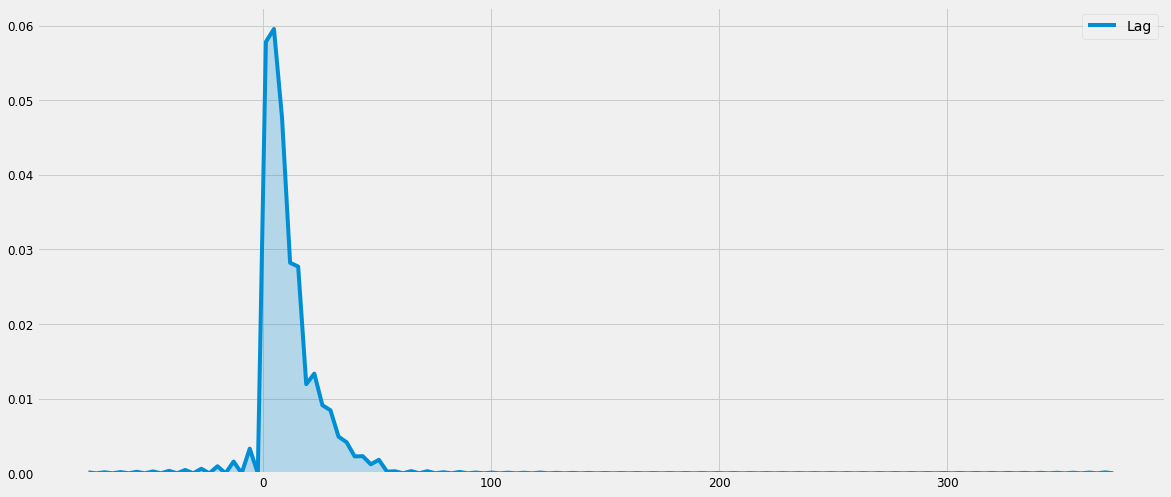

In [75]:
# Plotting lag distribution
sns.kdeplot(data["Lag"], shade=True)

In [76]:
data['Lag'].quantile(np.linspace(.99, 1, 100, 0))

0.9900     49.000
0.9901     49.000
0.9902     49.000
0.9903     49.000
0.9904     49.000
           ...   
0.9995     87.000
0.9996     88.982
0.9997    105.203
0.9998    122.491
0.9999    153.000
Name: Lag, Length: 100, dtype: float64

In [77]:
# From the above distributions, we see that there are very few records with > 60 days lag.
# For this analysis, we will assume that requests can be made only 2 months prior to the need.

# This is because we suspect that the very few requests with greater than 60 days might potentially be spurious data.
# We can always modify this assumption if necessary

In [78]:
# Removing above observations
data = data[data['Lag'] >= 0]
data = data[data['Lag'] <= 60]

Text(0,0.5,'Probability')

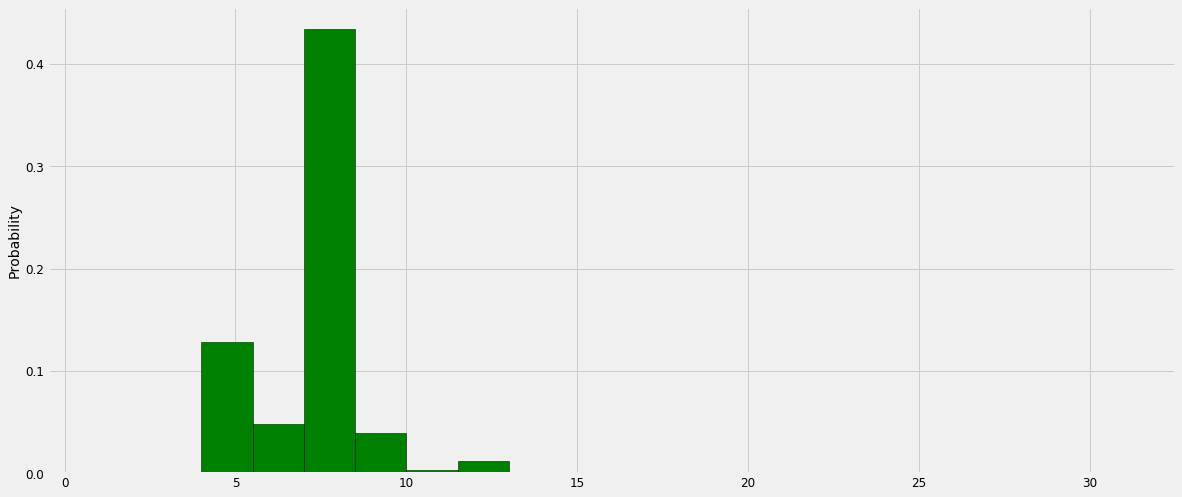

In [79]:
# Plotting a histogram to look at distribution of 'RequestHours'
plt.hist(x=data['RequestHours'], color='green', edgecolor='black', density=True, bins=20)
plt.ylabel('Probability')

In [80]:
# Looking at quantile values to get a better understanding for outliers
print(data['RequestHours'].quantile(np.linspace(.99, 1, 20, 0)))

0.9900    12.00
0.9905    12.00
0.9910    12.00
0.9915    12.50
0.9920    12.50
          ...  
0.9975    12.50
0.9980    19.00
0.9985    19.00
0.9990    19.02
0.9995    21.00
Name: RequestHours, Length: 20, dtype: float64


In [81]:
# From the above distributions, we see that there are very few records with > 12 hours requested.
# For this analysis, we will assume that a single request can be made for 12 hours at most.

# This is because we suspect that the very few requests with greater than 12 hour might potentially be spurious data.
# We can always modify this assumption if necessary

In [82]:
# Removing above observations
data = data[data['RequestHours'] <= 12]

___

## 5. Exploratory Data Analysis

### 5.1 Bar Plot

In [83]:
# Creating new variables called 'Day' and 'GrossRequests'
data['weekday'] = data['CareDateTime'].dt.day_name()
data['GrossRequests'] = 1

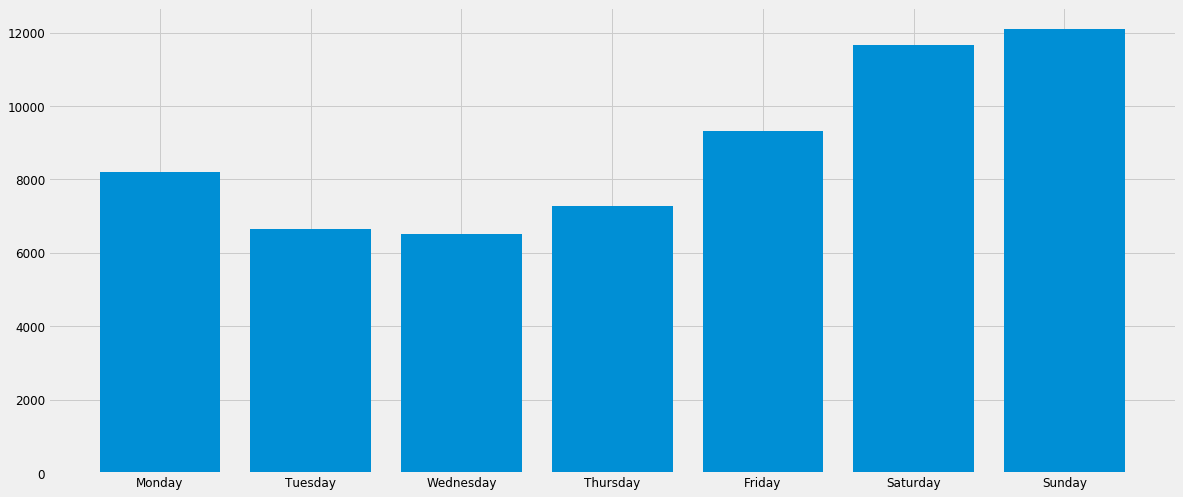

In [84]:
# Grouping by weekday to check probability density of Gross Requests
data_weekday = pd.DataFrame(data.groupby(['weekday']).sum())
reorderlist = [ 'Monday', 'Tuesday','Wednesday' ,'Thursday' ,'Friday', 'Saturday', 'Sunday']
data_weekday = data_weekday.reindex(reorderlist)

# Plotting to show seasonality effect for Gross Requests (Same pattern for Net Requests)
plt.bar(list(data_weekday.index),data_weekday['GrossRequests'])
plt.show()

#### The above bar graph shows a clear pattern with the weekends having a higher number of requests coming in compared to the middle of the week

### 5.2 Heat Map

In [85]:
# Transforming the data to get a matrix of 'Day' x 'Market' for Gross Requests
data_mkt = pd.pivot_table(data, values='GrossRequests',
                          index=['weekday'],
                          columns=['Market'],
                          aggfunc=np.sum)
data_mkt.head()

Market,BOS-Cape,BOS-North,BOS-South,BOS-West,CVG-1,JFK-1,PHL-1,PHL-2,PIT-1,PSM-1,PVD-1
weekday,,,,,,,,,,,
Friday,650.0,1089.0,1726.0,335.0,279.0,NaN,2065.0,634.0,1149.0,1.0,1391.0
Monday,608.0,881.0,1586.0,437.0,216.0,1.0,1622.0,463.0,1287.0,1.0,1113.0
Saturday,635.0,1325.0,2155.0,469.0,272.0,NaN,2763.0,779.0,1600.0,6.0,1669.0
Sunday,625.0,1644.0,2308.0,506.0,247.0,NaN,2823.0,638.0,1513.0,1.0,1794.0
Thursday,542.0,867.0,1360.0,264.0,176.0,NaN,1561.0,504.0,1090.0,NaN,926.0


In [86]:
# Creating dummy variables for status
data_status = pd.get_dummies(data['status'])
data_new = pd.concat([data, data_status], axis=1)

# Creating new column called 'NetRequests' to calculate requests net of deletions
data_new['NetRequests'] = data_new['GrossRequests'] - data_new['Deleted']

data_new.head()

,RequestId,Market,CareDateTime,RequestTime,RequestHours,TimeGroup,RequestQualification,status,FinalStatusTime,Lag,weekday,GrossRequests,Completed,Deleted,Incompleted,NetRequests
42,596490,PIT-1,2018-10-02,2018-08-13,8.0,NT,Nurse,Completed,2018-10-03,50,Tuesday,1,1,0,0,1
44,598214,BOS-Cape,2018-10-01,2018-08-14,8.0,ET,CNA,Completed,2018-10-01,48,Monday,1,1,0,0,1
45,598214,BOS-Cape,2018-10-01,2018-08-14,8.0,ET,CNA,Completed,2018-10-01,48,Monday,1,1,0,0,1
46,598216,BOS-Cape,2018-10-01,2018-08-14,6.0,ET,CNA,Incompleted,2018-10-01,48,Monday,1,0,0,1,1
47,598216,BOS-Cape,2018-10-01,2018-08-14,6.0,ET,CNA,Incompleted,2018-10-01,48,Monday,1,0,0,1,1


In [87]:
# Transforming the data to get a matrix of 'Day' x 'Market' for Net Requests
data_mktnet = pd.pivot_table(data_new, values='NetRequests',
                          index=['weekday'],
                          columns=['Market'],
                          aggfunc=np.sum)
data_mktnet.head()

Market,BOS-Cape,BOS-North,BOS-South,BOS-West,CVG-1,JFK-1,PHL-1,PHL-2,PIT-1,PSM-1,PVD-1
weekday,,,,,,,,,,,
Friday,321.0,529.0,870.0,163.0,141.0,NaN,1220.0,320.0,698.0,1.0,783.0
Monday,289.0,435.0,826.0,202.0,88.0,1.0,907.0,224.0,771.0,1.0,645.0
Saturday,278.0,639.0,1049.0,240.0,157.0,NaN,1556.0,407.0,873.0,6.0,919.0
Sunday,305.0,841.0,1150.0,253.0,140.0,NaN,1693.0,276.0,886.0,1.0,991.0
Thursday,265.0,398.0,661.0,121.0,104.0,NaN,872.0,237.0,602.0,NaN,522.0


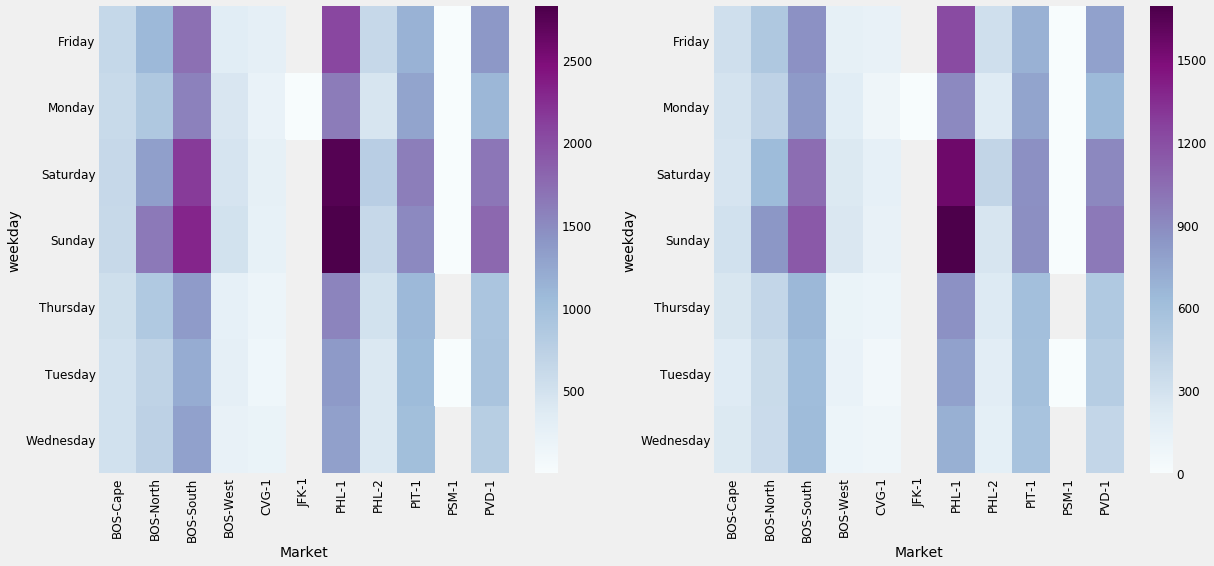

In [88]:
# Plotting heat maps to show absolute number of requests and net requests that come in through the week across markets
fig, (ax1, ax2) = plt.subplots(1,2)
sns.heatmap(data_mkt, cmap='BuPu', ax=ax1)
sns.heatmap(data_mktnet, cmap='BuPu', ax=ax2)
plt.show()

#### The above plots show almost the exact distribution of requests from each market with BOS-South and PHL-1 receiving the most requests, whereas JFK-1 and PSM-1 barely have requests

### 5.3 Plot for Market

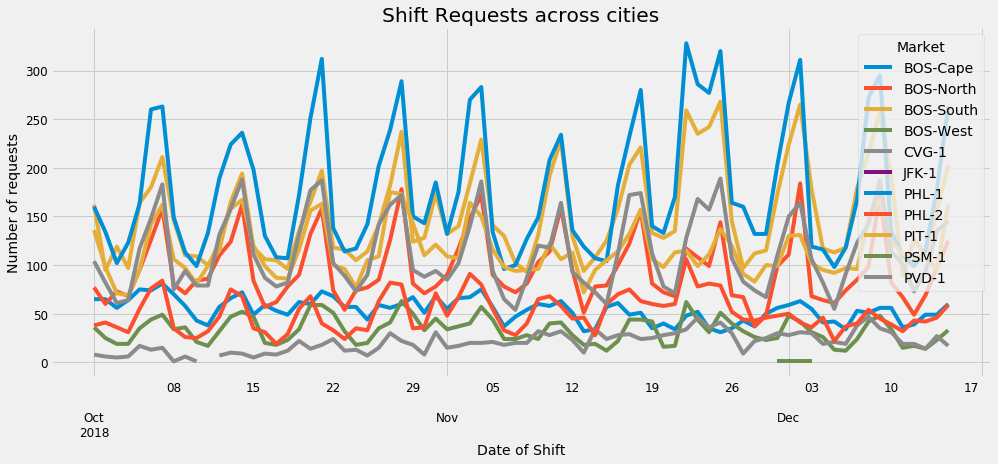

In [89]:
# Gross Requests across Markets over Time

data_grosstime = pd.pivot_table(data_new, values='GrossRequests',
                          index=['CareDateTime'],
                          columns=['Market'],
                          aggfunc=np.sum)

data_grosstime.plot(figsize=(15, 6))
plt.xlabel('Date of Shift')
plt.ylabel('Number of requests')
plt.title('Shift Requests across cities')
plt.show()

#### From the heat maps by region and from the plot above, since the markets have different demand we can conclude that each market needs to be forecasted separately
___

## 6. Time Series Analysis

### 6.1 Building a master dataset

In [90]:
# Creating master dataset for  gross requests analysis
masterdata_gross = pd.pivot_table(data_new, values='GrossRequests',
                          index=['CareDateTime'],
                          columns=['Market'],
                          aggfunc=np.sum)

In [91]:
# Creating a master dataset for net requests analysis
masterdata_net = pd.pivot_table(data_new, values='NetRequests',
                          index=['CareDateTime'],
                          columns=['Market'],
                          aggfunc=np.sum)

In [92]:
masterdata_gross.head()
# masterdata_net.head()

Market,BOS-Cape,BOS-North,BOS-South,BOS-West,CVG-1,JFK-1,PHL-1,PHL-2,PIT-1,PSM-1,PVD-1
CareDateTime,,,,,,,,,,,
2018-10-01,65.0,77.0,162.0,36.0,8.0,NaN,160.0,38.0,136.0,NaN,104.0
2018-10-02,65.0,60.0,95.0,25.0,6.0,NaN,134.0,41.0,98.0,NaN,82.0
2018-10-03,56.0,73.0,119.0,19.0,5.0,NaN,102.0,36.0,71.0,NaN,61.0
2018-10-04,64.0,68.0,97.0,19.0,6.0,NaN,123.0,31.0,69.0,NaN,64.0
2018-10-05,75.0,95.0,164.0,35.0,17.0,NaN,163.0,55.0,95.0,NaN,117.0


### 6.2 Time Series Analysis for 'BOS-Cape' Market

#### Now that we have our master dataset, let's first observe the time series for a single market 'BOS-Cape'

In [93]:
# Net Requests for BOS-South
BOS_Cape_Gross = masterdata_gross[masterdata_gross.columns[0]]
BOS_Cape_Gross.head()

CareDateTime
2018-10-01    65.0
2018-10-02    65.0
2018-10-03    56.0
2018-10-04    64.0
2018-10-05    75.0
Name: BOS-Cape, dtype: float64

#### Seasonal Autoregressive Integrated Moving Average (SARIMA) time series models are created for each individual market of interest, to forecast the number of requests over time within them.


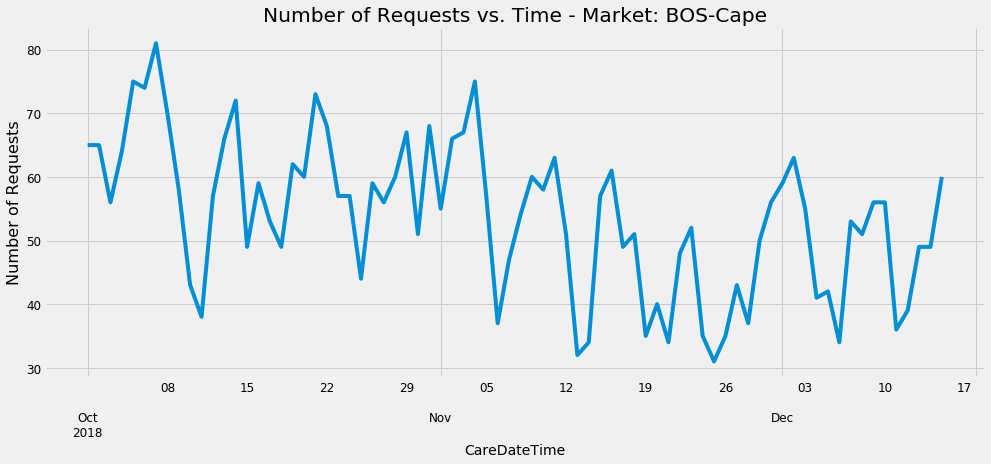

In [94]:
y = masterdata_gross.iloc[:,0]
y_col_name = masterdata_gross.columns[0]

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

ax = y.plot(figsize=(15, 6), title=(('Number of Requests vs. Time - Market: ' + str(y_col_name))))
plt.ylabel('Number of Requests', fontsize=16)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.show()

#### The time series is then decomposed into it's trend, seasonal and noise components, and then visualized


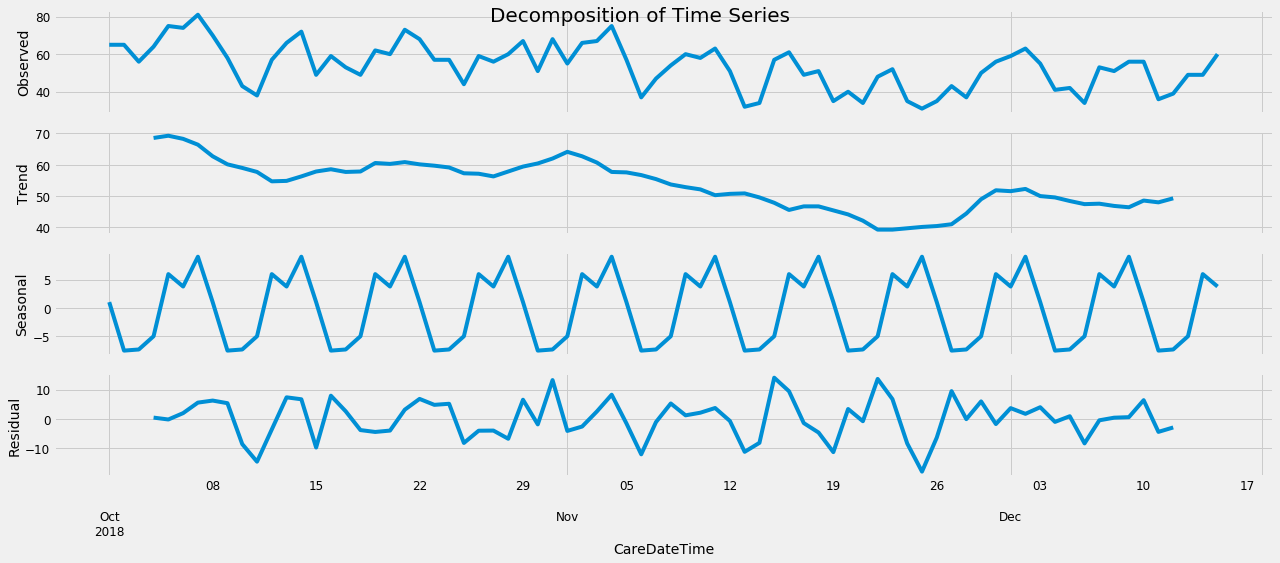

In [95]:
# Decomposing TS to trend seasonality and noise
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
fig.suptitle('Decomposition of Time Series', fontsize=20)
plt.show()

#### A clear seasonal and a subtle trend pattern is observed in the above chart.

#### A parameter grid is then created to run a 'grid search' to find the optimal set of parameters that yeilds the best performance for the model. The parameters are selected based on the model that generates the lowest AIC.¶


In [96]:
# Creating a grid of parameters
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
# choosing the best parameters (grid search)
best_aic = 1000000.00
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_para = param
                best_para_seas = param_seasonal
                best_aic = results.aic
        except:
            continue

print('The AIC for the best parameters for the model on this market is: {}'.format(round(best_aic, 2)))

The AIC for the best parameters for the model on this market is: 435.07


#### An ARIMA model is then fitted to the time series using the best parameters found¶

In [97]:
# Fitting ARIMA model with best parameters
mod = sm.tsa.statespace.SARIMAX(y, order=best_para, seasonal_order=best_para_seas, enforce_stationarity=True, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4382      0.176      2.489      0.013       0.093       0.783
ma.L1         -0.9346      0.114     -8.211      0.000      -1.158      -0.712
ma.S.L7       -0.7885      0.122     -6.438      0.000      -1.029      -0.548
sigma2        73.5811     14.925      4.930      0.000      44.329     102.833


#### The model diagnostic is then run to investigate any unusual behavior¶

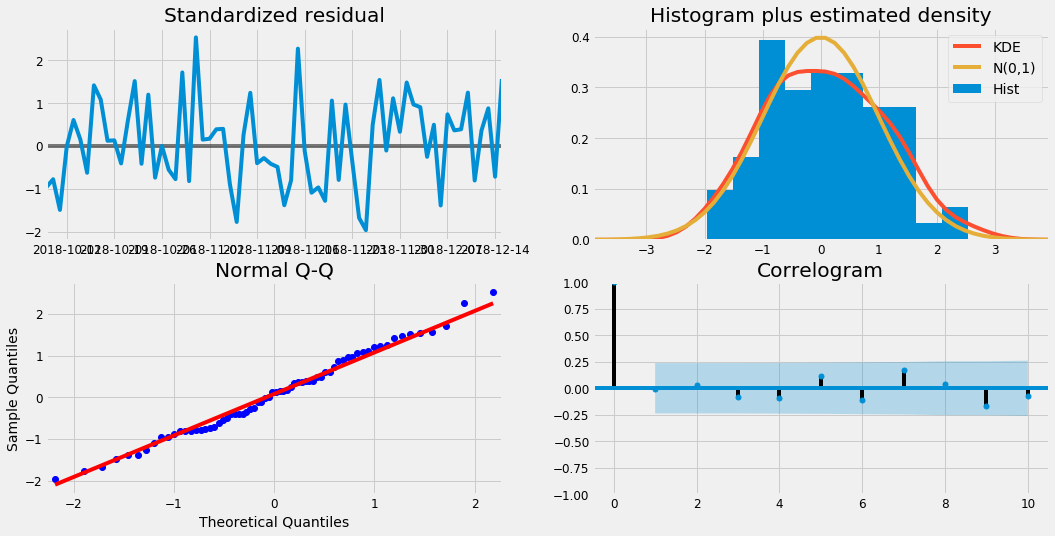

In [98]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### The model diagnostics suggests that the model residuals are near normally distributed.

#### The model forecast is then visualized with the true value to help visually validate the forecast.

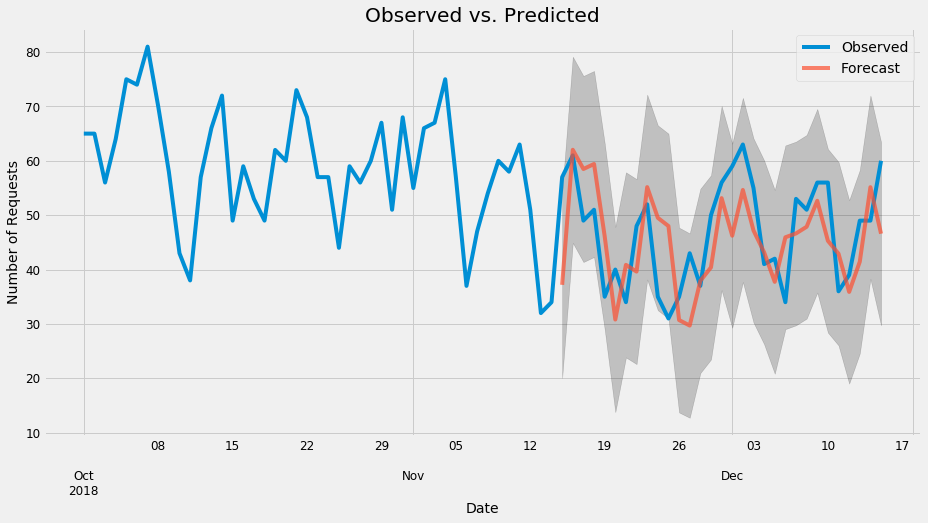

In [99]:
# validating forecast
pred = results.get_prediction(start=pd.to_datetime('2018-11-15'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2018':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Requests')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.title('Observed vs. Predicted')
plt.legend()
plt.show()


#### The MSE and RMSE are then calculated to assess the error in the forecast

In [100]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-11-15':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 85.61
The Root Mean Squared Error of our forecasts is 9.25


#### Root Mean Square Error (RMSE) tells us that our model was able to forecast the average number of requests within 9.25 of the true number. This is fairly good considering the true number of requests is much higher

#### Forecasts are then made 6 days into the future and visualized as requested

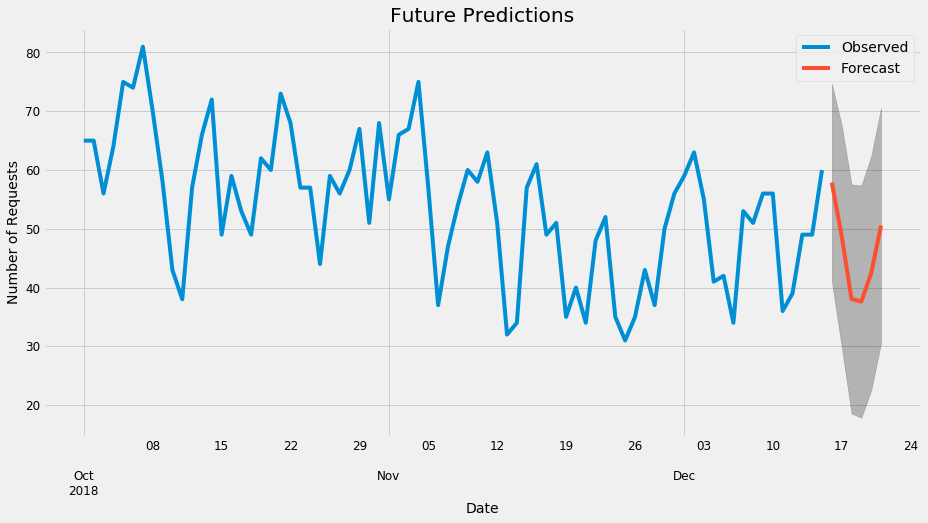

In [101]:
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Requests')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.title('Future Predictions')
plt.legend()
plt.show()

#### A main dataset is created to hold the forecasts of the remaining markets

In [102]:
pred_uc = results.get_forecast(steps=6)
forecast_final_p1 = pd.DataFrame(pred_uc.predicted_mean, columns=[str(y_col_name)])

forecast_final_p1 = forecast_final_p1.tail(1)
forecast_final_p1 = forecast_final_p1.rename(index = {forecast_final_p1.index[0]: 'Predicted Requests'})

forecast_final = forecast_final_p1
forecast_final


,BOS-Cape
Predicted Requests,50.552325


### 6.3 An ARIMA time series model is now created for all the remaining markets for both gross and net requests

In [58]:
# Creating a master for gross request predictions
for i in range(1,11):
    y = masterdata_gross.iloc[:,i]
    y_col_name = masterdata_gross.columns[i]
    best_aic = 1000000.00
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=True, enforce_invertibility=False)
                results = mod.fit()
                if results.aic < best_aic:
                    best_para = param
                    best_para_seas = param_seasonal
                    best_aic = results.aic
            except:
                continue
    mod = sm.tsa.statespace.SARIMAX(y, order=best_para, seasonal_order=best_para_seas, enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    # checking rmse
    pred = results.get_prediction(start=pd.to_datetime('2018-11-15'), dynamic=False)
    y_forecasted = pred.predicted_mean
    y_truth = y['2018-11-15':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Root Mean Squared Error of the forecast for market: {} is {}'.format(y_col_name,'{:,.2f}'.format(round(np.sqrt(mse), 2))))
    #make predictions
    pred_uc = results.get_forecast(steps=6)
    forecast_final_p1 = pd.DataFrame(pred_uc.predicted_mean, columns=[str(y_col_name)])
    forecast_final_p1 = forecast_final_p1.tail(1)
    forecast_final_p1 = forecast_final_p1.rename(index = {forecast_final_p1.index[0]: 'Predicted Requests'})
    fin = forecast_final_p1
    forecast_final = pd.merge(forecast_final, fin, how='inner', left_index=True, right_index=True)

gross_forecast = forecast_final

The Root Mean Squared Error of the forecast for market: BOS-North is 16.20
The Root Mean Squared Error of the forecast for market: BOS-South is 31.43
The Root Mean Squared Error of the forecast for market: BOS-West is 10.68
The Root Mean Squared Error of the forecast for market: CVG-1 is 7.25
The Root Mean Squared Error of the forecast for market: JFK-1 is 1.00
The Root Mean Squared Error of the forecast for market: PHL-1 is 39.05
The Root Mean Squared Error of the forecast for market: PHL-2 is 14.73
The Root Mean Squared Error of the forecast for market: PIT-1 is 14.17
The Root Mean Squared Error of the forecast for market: PSM-1 is 2.24
The Root Mean Squared Error of the forecast for market: PVD-1 is 13.28


In [104]:
# Creating a master for net request predictions

for i in range(0,11):
    z = masterdata_net.iloc[:,i]
    z_col_name = masterdata_net.columns[i]
    best_aic = 1000000.00
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(z, order=param, seasonal_order=param_seasonal, enforce_stationarity=True, enforce_invertibility=False)
                results = mod.fit()
                if results.aic < best_aic:
                    best_para = param
                    best_para_seas = param_seasonal
                    best_aic = results.aic
            except:
                continue
    mod = sm.tsa.statespace.SARIMAX(z, order=best_para, seasonal_order=best_para_seas, enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    # checking rmse
    pred = results.get_prediction(start=pd.to_datetime('2018-11-15'), dynamic=False)
    z_forecasted = pred.predicted_mean
    z_truth = z['2018-11-15':]
    mse = ((z_forecasted - z_truth) ** 2).mean()
    print('The Root Mean Squared Error of the forecast for market: {} is {}'.format(z_col_name,'{:,.2f}'.format(round(np.sqrt(mse), 2))))
    #make predictions
    pred_uc = results.get_forecast(steps=6)
    forecast_final_p1 = pd.DataFrame(pred_uc.predicted_mean, columns=[str(z_col_name)])
    forecast_final_p1 = forecast_final_p1.tail(1)
    forecast_final_p1 = forecast_final_p1.rename(index = {forecast_final_p1.index[0]: 'Predicted Requests'})
    fin = forecast_final_p1
    forecast_final = pd.merge(forecast_final, fin, how='inner', left_index=True, right_index=True)
    
net_forecast = forecast_final.drop(columns=['BOS-Cape_x']) 

The Root Mean Squared Error of the forecast for market: BOS-Cape is 6.90
The Root Mean Squared Error of the forecast for market: BOS-North is 10.60
The Root Mean Squared Error of the forecast for market: BOS-South is 19.24
The Root Mean Squared Error of the forecast for market: BOS-West is 6.59
The Root Mean Squared Error of the forecast for market: CVG-1 is 5.83
The Root Mean Squared Error of the forecast for market: JFK-1 is 1.00
The Root Mean Squared Error of the forecast for market: PHL-1 is 27.17
The Root Mean Squared Error of the forecast for market: PHL-2 is 9.70
The Root Mean Squared Error of the forecast for market: PIT-1 is 10.30
The Root Mean Squared Error of the forecast for market: PSM-1 is 2.20
The Root Mean Squared Error of the forecast for market: PVD-1 is 11.46


___

## 7. Predicted number of requests

In [105]:
# Given below is a table for predicted net requests for 2018-12-21 which is 6 days
# after the last date given in the dataset
net_forecast

,BOS-Cape_y,BOS-North,BOS-South,BOS-West,CVG-1,JFK-1,PHL-1,PHL-2,PIT-1,PSM-1,PVD-1
Predicted Requests,24.507554,48.090728,68.799169,14.818147,14.776657,0.0,111.020186,21.524104,69.298934,0.0,80.058488


In [59]:
# Given below is a table for predicted requests for 2018-12-21 which is 6 days
# after the last date given in the dataset
gross_forecast

,BOS-Cape,BOS-North,BOS-South,BOS-West,CVG-1,JFK-1,PHL-1,PHL-2,PIT-1,PSM-1,PVD-1
Predicted Requests,50.552325,94.338989,181.190017,21.98656,29.067645,0.0,197.614159,45.62977,111.993196,0.0,124.630683


___

## 8. Recommendations

- Collect longer periods for better prediction
- Implement checks to ensure data is entered correctly in the observation log (We had negative values and outliers for Request Hours & Lag Days)
- Combine dataset with rates to see which markets are profitable